# 01 — Exploratory Data Analysis (EPL 2019‑2024)

*Generated 2025-05-30.*  
This notebook loads the **processed** dataset created by the ETL pipeline (`data/processed/merged.parquet`) and provides a concise exploratory overview:

1. Basic shape & schema  
2. Descriptive statistics  
3. Goal distributions  
4. Expected‑goals (xG) distributions  
5. xG vs. actual goal difference scatter  
6. Bookmaker implied probabilities  
7. Class balance for match outcome target  

Feel free to extend with further EDA (e.g., correlation heat‑map, season‑by‑season analysis, team‑level aggregates).

In [1]:
%pip install -q fastparquet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
from pathlib import Path

DATA_PATH = Path("../data/processed/merged.parquet")
assert DATA_PATH.exists(), f"{DATA_PATH} not found. Run merge pipeline first."

df = pd.read_parquet(DATA_PATH)
print(f"Shape: {df.shape}")
df.head()

Shape: (2130, 15)


,date,home_team,away_team,home_goals,away_goals,xG_home,xG_away,bookie_home,bookie_draw,bookie_away,result,bookie_sum,bookie_prob_home,bookie_prob_draw,bookie_prob_away
0,2020-01-01,Watford,Wolves,2,1,1.07053,1.232520,3.00,3.40,2.30,H,1.062234,0.313804,0.276886,0.409310
1,2020-01-01,Brighton,Chelsea,1,1,1.56978,1.574970,3.60,3.60,1.95,D,1.068376,0.260000,0.260000,0.480000
2,2020-01-01,Arsenal,Man United,2,0,1.90747,0.715563,2.55,3.60,2.62,H,1.051614,0.372910,0.264144,0.362946
3,2020-01-01,West Ham,Bournemouth,4,0,2.32825,0.720709,1.90,3.75,3.80,H,1.056140,0.498339,0.252492,0.249169
4,2020-01-01,Norwich,Crystal Palace,1,1,1.66454,1.298960,2.50,3.40,2.75,D,1.057754,0.378160,0.278059,0.343782


In [3]:
df.info()
df.describe().T.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2130 entries, 0 to 2129
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              2130 non-null   datetime64[ns]
 1   home_team         2130 non-null   object        
 2   away_team         2130 non-null   object        
 3   home_goals        2130 non-null   int64         
 4   away_goals        2130 non-null   int64         
 5   xG_home           2130 non-null   float64       
 6   xG_away           2130 non-null   float64       
 7   bookie_home       2130 non-null   float64       
 8   bookie_draw       2130 non-null   float64       
 9   bookie_away       2130 non-null   float64       
 10  result            2130 non-null   object        
 11  bookie_sum        2130 non-null   float64       
 12  bookie_prob_home  2130 non-null   float64       
 13  bookie_prob_draw  2130 non-null   float64       
 14  bookie_prob_away  2130 n

,count,mean,min,25%,50%,75%,max,std
date,2130,2022-08-07 18:40:54.084507136,2019-08-09 00:00:00,2021-02-17 12:00:00,2022-08-27 12:00:00,2024-01-30 00:00:00,2025-05-25 00:00:00,NaN
home_goals,2130.0,1.565258,0.0,1.0,1.0,2.0,9.0,1.340105
away_goals,2130.0,1.330047,0.0,0.0,1.0,2.0,9.0,1.215405
xG_home,2130.0,1.642443,0.020346,0.898599,1.49144,2.260082,6.67151,0.952783
xG_away,2130.0,1.364157,0.020989,0.717315,1.222875,1.82019,5.8331,0.866362


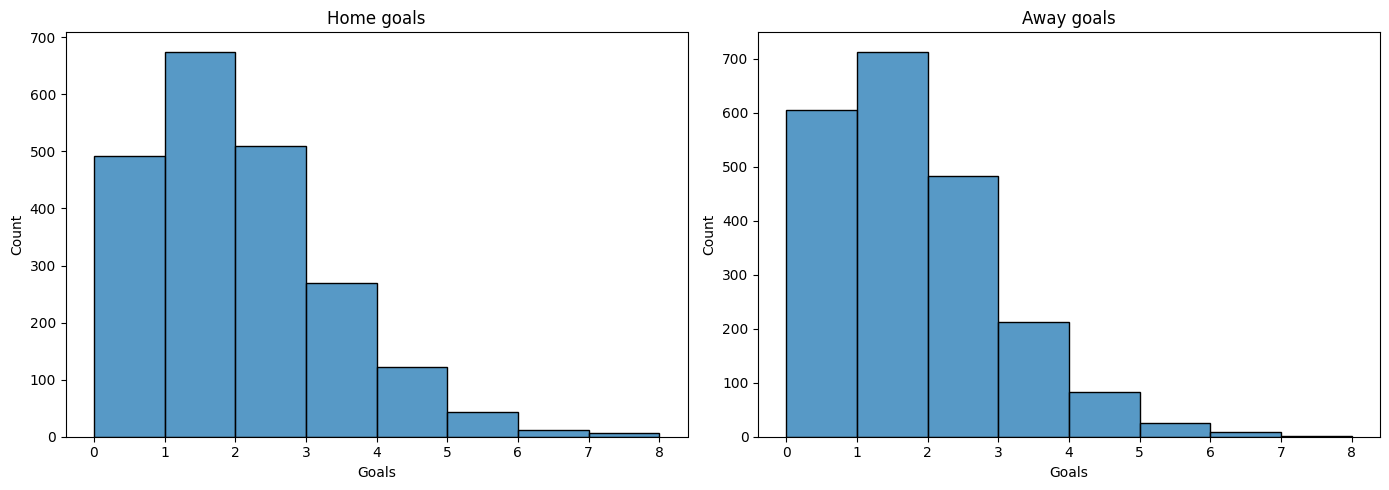

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df['home_goals'], bins=range(0, 9), ax=ax[0])
ax[0].set(title='Home goals', xlabel='Goals')
sns.histplot(df['away_goals'], bins=range(0, 9), ax=ax[1])
ax[1].set(title='Away goals', xlabel='Goals')
plt.tight_layout()
plt.show()

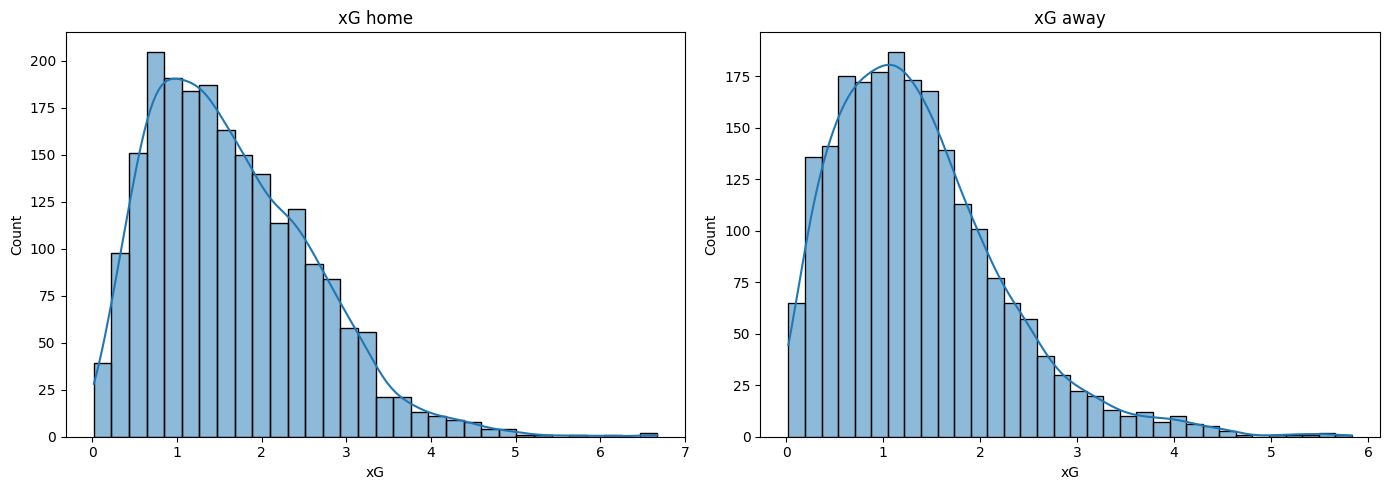

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df['xG_home'], kde=True, ax=ax[0])
ax[0].set(title='xG home', xlabel='xG')
sns.histplot(df['xG_away'], kde=True, ax=ax[1])
ax[1].set(title='xG away', xlabel='xG')
plt.tight_layout()
plt.show()

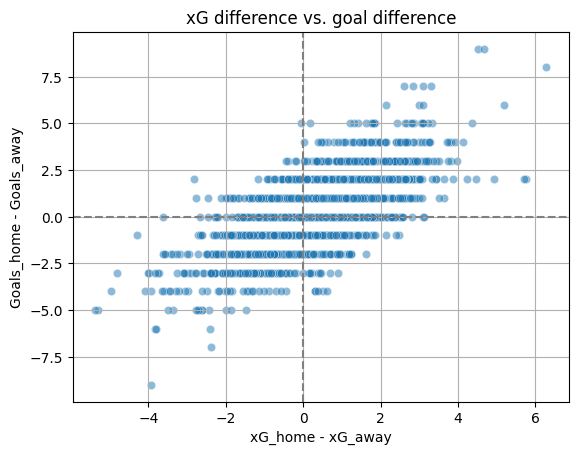

In [7]:
df['xg_diff'] = df['xG_home'] - df['xG_away']
df['goal_diff'] = df['home_goals'] - df['away_goals']

sns.scatterplot(data=df, x='xg_diff', y='goal_diff', alpha=0.5)
plt.axhline(0, ls='--', c='grey')
plt.axvline(0, ls='--', c='grey')
plt.title('xG difference vs. goal difference')
plt.xlabel('xG_home - xG_away')
plt.ylabel('Goals_home - Goals_away')
plt.grid(True)
plt.show()

In [8]:
# already computed in merge pipeline; recalc defensive
df['bookie_sum'] = 1/df['bookie_home'] + 1/df['bookie_draw'] + 1/df['bookie_away']
df['bookie_prob_home'] = (1/df['bookie_home']) / df['bookie_sum']
df['bookie_prob_draw'] = (1/df['bookie_draw']) / df['bookie_sum']
df['bookie_prob_away'] = (1/df['bookie_away']) / df['bookie_sum']

df[['bookie_prob_home','bookie_prob_draw','bookie_prob_away']].describe()

,bookie_prob_home,bookie_prob_draw,bookie_prob_away
count,2130.000000,2130.000000,2130.000000
mean,0.437853,0.236774,0.325373
std,0.195537,0.048764,0.178826
min,0.049896,0.072914,0.032691
25%,0.288462,0.210690,0.180818
50%,0.422179,0.250217,0.297530
75%,0.582693,0.271773,0.437978
max,0.894382,0.338762,0.831601


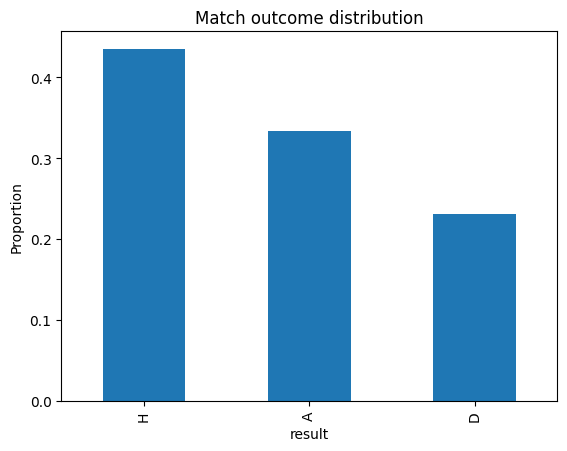

In [9]:
df['result'].value_counts(normalize=True).plot(kind='bar', title='Match outcome distribution')
plt.ylabel('Proportion')
plt.show()